In [71]:
import numpy as np
import anndata
import pandas as pd
import os
from src import preprocess, get_hg_reduction, reduce, scatterplot, knn_auto
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
import seaborn as sns
from sklearn.metrics import adjusted_rand_score as ARI
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Run Methods on Datasets

In [4]:
# Identify cell type columns in each dataset
DATA_LOG = []
resolutions = [i/10 for i in range(5,16)]
CT_COLS = {
    'darmanis_brain.h5ad': 'cell.type',
    'romanov_brain.h5ad': 'labels',
    'zhong_prefrontal.h5ad': 'cell_types',
    'lawlow_pancreas.h5ad': 'cell type',
    'hermann_spermatogenesis.h5ad': 'celltype',
    'ReprocessedAllenData.h5ad': 'Primary.Type',
}

In [ ]:
for dataset in os.listdir("data"):

    if (
        (dataset in DATA_LOG and len(DATA_LOG[dataset]) == len(resolutions) ** 2)
        or (not dataset.endswith('.h5ad'))
        or (dataset not in CT_COLS)
    ):
        continue
        
    print(f"Running {dataset}")
    
    dataset_fn = os.path.join("data", dataset)

    # Read in data
    adata = anndata.read_h5ad(dataset_fn)
    adata = preprocess(
        adata,
        filter_genes=True,
        normalize=True,
        log1p=True,
        high_var=True,
        scale=True,
    )
    
    # Add cell type to 'labels'
    adata.obs['labels'] = adata.obs[CT_COLS[dataset]]

    # this is sparse
    reduced_adj = get_hg_reduction(adata.X, n_clusters=4)
    print(f"Adjacency matrix has shape {reduced_adj.shape}")
    order = np.argsort(adata.obs['labels']) # cells ordered so we can see blocks in the heatmap
    
    # Construct graph using reduced adj
    sources, targets = reduced_adj.nonzero()
    weights = np.array(reduced_adj[sources, targets])
    gg = ig.Graph(directed=False)
    
    gg.add_vertices(adata.shape[0]) # cells
    gg.add_edges(list(zip(list(sources), list(targets))))

    # Construct graph with KNN
    sources_base, targets_base, weights_base = knn_auto(adata.X)
    gg_base = ig.Graph(directed=False)
    gg_base.add_vertices(adata.shape[0]) # cells
    gg_base.add_edges(list(zip(list(sources_base), list(targets_base))))

    for i in range(5):
    
        for res_reduced in resolutions:

            ## Run Leiden - Reduced Adj
            part = la.find_partition(
                gg,
                la.RBConfigurationVertexPartition,
                weights=weights.flatten(),
                resolution_parameter=res_reduced,
            )
            predictions_reduced_hg = np.array(part.membership, dtype=int)
            score_reduced = ARI(predictions_reduced_hg, adata.obs['labels'])

            DATA_LOG.append({
                'dataset': dataset,
                'score': score_reduced,
                'res': res_reduced,
                'method': 'reduced',
                'trial': i,
            })

        for res_base in resolutions:

            ## Run Leiden - KNN
            part_base = la.find_partition(
                gg_base,
                la.RBConfigurationVertexPartition,
                resolution_parameter=res_base,
            )
            predictions_base = np.array(part_base.membership, dtype=int)
            score_base = ARI(predictions_base, adata.obs['labels'])

            DATA_LOG.append({
                'dataset': dataset,
                'score': score_base,
                'res': res_base,
                'method': 'base',
                'trial': i,
            })

In [23]:
datasets = [k for k in os.listdir("data") if k.endswith('.h5ad')]

In [72]:
datasets

['darmanis_brain.h5ad',
 'romanov_brain.h5ad',
 'zhong_prefrontal.h5ad',
 'lawlow_pancreas.h5ad',
 'ReprocessedAllenData.h5ad',
 'hermann_spermatogenesis.h5ad']

In [9]:
df = pd.DataFrame(DATA_LOG)
group_df = df.groupby(['dataset', 'res', 'method'])['score'].describe()

In [66]:
group_df

,dataset,res,method,count,mean,std,min,25%,50%,75%,max
0,darmanis_brain.h5ad,0.5,base,5.0,0.396939,0.027762,0.364021,0.390231,0.390231,0.399661,0.440550
1,darmanis_brain.h5ad,0.5,reduced,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,darmanis_brain.h5ad,0.6,base,5.0,0.443408,0.000000,0.443408,0.443408,0.443408,0.443408,0.443408
3,darmanis_brain.h5ad,0.6,reduced,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,darmanis_brain.h5ad,0.7,base,5.0,0.457723,0.001707,0.455806,0.456748,0.457674,0.458032,0.460357
...,...,...,...,...,...,...,...,...,...,...,...
17,ReprocessedAllenData.h5ad,1.3,reduced,5.0,0.435708,0.014422,0.420725,0.423457,0.432952,0.450704,0.450704
18,ReprocessedAllenData.h5ad,1.4,base,5.0,0.405226,0.006943,0.393992,0.404547,0.407422,0.407422,0.412744
19,ReprocessedAllenData.h5ad,1.4,reduced,5.0,0.418243,0.004831,0.411631,0.415093,0.420344,0.420344,0.423801
20,ReprocessedAllenData.h5ad,1.5,base,5.0,0.414760,0.003017,0.411394,0.411517,0.416949,0.416949,0.416993


In [86]:
group_df.to_csv('output/leiden_data.csv', index=False)

# Data Analysis

In [11]:
group_df = pd.read_csv('output/leiden_data.csv')
datasets = group_df['dataset'].unique()

In [79]:
true_titles = {
    'ReprocessedAllenData.h5ad': 'Tasic et al. (2016)\n Mouse Visual Cortex',
    'darmanis_brain.h5ad': 'Darmanis et al. (2015)\n Human Brain',
    'hermann_spermatogenesis.h5ad': 'Hermann et al. (2018)\n Mouse Spermatogenic Cells',
    'lawlow_pancreas.h5ad': 'Lawlor et al. (2017)\n Human Pancreas', 
    'romanov_brain.h5ad': 'Romanov et al. (2017)\n Mouse Brain', 
    'zhong_prefrontal.h5ad': 'Zhong et al. (2018)\n Human Prefrontal Cortex', 
}

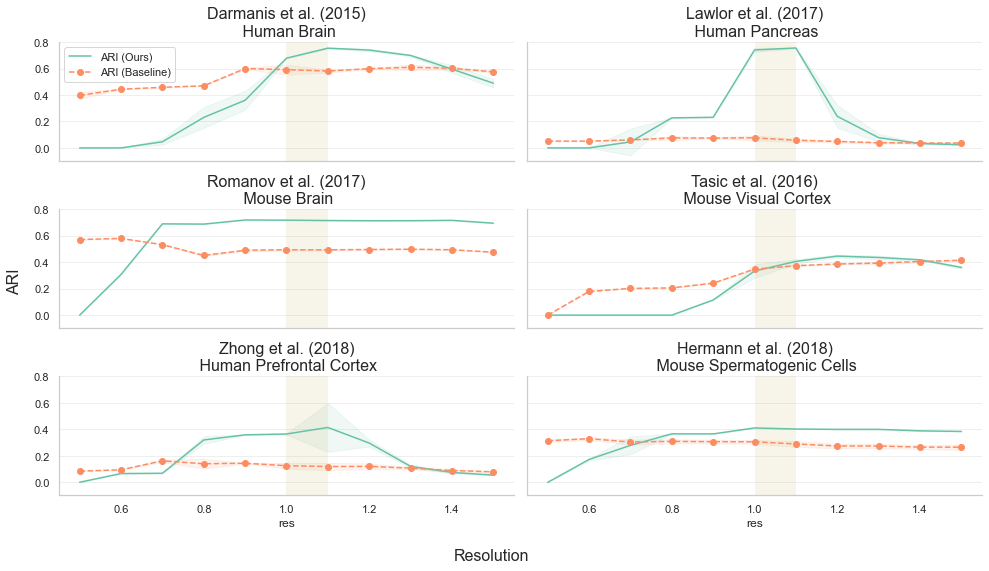

In [83]:
sns.set_palette("Set2")
sns.set_style("whitegrid")
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
fig.set_size_inches(14, 8)
fig.tight_layout(pad=5)
for i, dataset in enumerate(datasets):
    ax = axs[i % 3, i // 3]
    
    sub_df = group_df[(group_df['dataset'] == dataset) & (group_df['method'] == 'reduced')]
    sub_df['ARI (Ours)'] = sub_df['mean']
    sub_df.plot(y='ARI (Ours)', x='res', ax=ax)
    
    sstd = sub_df['std']
    yy = sub_df['mean']
    x = sub_df['res']
    ax.fill_between(x, yy - sstd, yy + sstd, color='C0', alpha=0.1)
    
    sub_df = group_df[(group_df['dataset'] == dataset) & (group_df['method'] == 'base')]
    sub_df['ARI (Baseline)'] = sub_df['mean']
    sub_df.plot(y='ARI (Baseline)', x='res', ax=ax, style='--', marker='o')
    
    sstd = sub_df['std']
    yy = sub_df['mean']
    x = sub_df['res']
    ax.fill_between(x, yy - sstd, yy + sstd, color='C1', alpha=0.1)
    
    ax.axvspan(1, 1.1, color='y', alpha=0.15, lw=0)
    ax.set_title(f"{true_titles[dataset]}", fontsize=16)
    ax.grid(False)
    ax.grid(True, which='major', axis='y', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if i != 0:
        ax.get_legend().remove()

        
fig.supxlabel('Resolution', fontsize=16)
fig.supylabel('ARI', fontsize=16)
fig.tight_layout()
plt.savefig("output/two_col_ARI.svg")


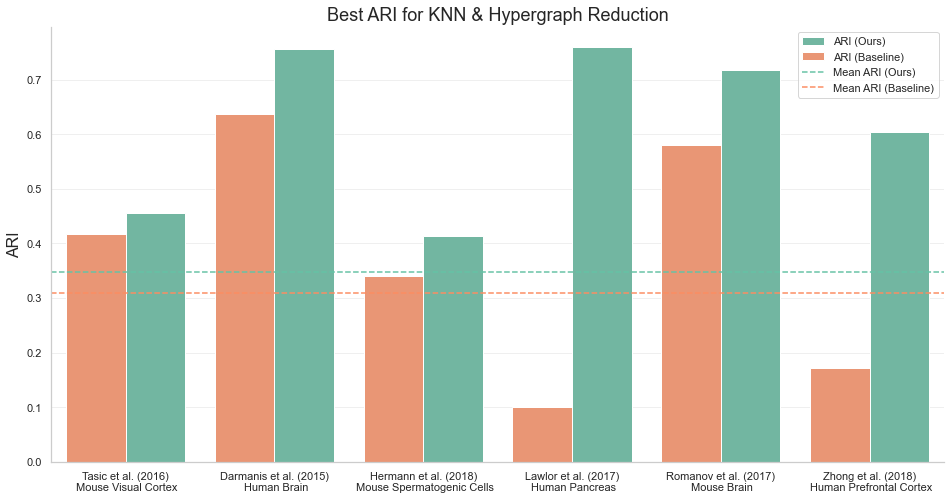

In [84]:
ax = sns.barplot(x="dataset", y="max", hue="method", palette=['C1', 'C0'], data=group_df[['dataset', 'method', 'max']].groupby(['dataset', 'method']).max().reset_index())
ax.set_ylabel("ARI", fontsize = 16)
ax.set_xlabel(None)
ax.set_title("Best ARI for KNN & Hypergraph Reduction", fontsize=18)
line1 = plt.axhline(y=group_df[group_df['method'] == 'reduced']['max'].mean(), linestyle='--', color='C0')
line2 = plt.axhline(y=group_df[group_df['method'] == 'base']['max'].mean(), linestyle='--', color='C1')

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
handles += [line1, line2]
labels = ['ARI (Ours)', 'ARI (Baseline)', 'Mean ARI (Ours)', 'Mean ARI (Baseline)']
ax.legend(handles, labels)

ax.set_xticklabels( true_titles.values() )
plt.xticks(rotation = 0)
ax.grid(False)
ax.grid(True, which='major', axis='y', alpha=0.3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('output/best_ari.svg')

In [58]:
group_df[group_df['method'] == 'reduced'].sort_values('mean').drop_duplicates(['dataset','method'],keep='last')

,dataset,res,method,count,mean,std,min,25%,50%,75%,max
55,hermann_spermatogenesis.h5ad,1.0,reduced,5.0,0.411319,0.001108,0.410223,0.410223,0.411661,0.411661,0.412827
123,zhong_prefrontal.h5ad,1.1,reduced,5.0,0.414937,0.183622,0.210438,0.226190,0.496040,0.538389,0.603630
15,ReprocessedAllenData.h5ad,1.2,reduced,5.0,0.446058,0.011302,0.429886,0.438744,0.452467,0.452467,0.456725
97,romanov_brain.h5ad,0.9,reduced,5.0,0.718945,0.000000,0.718945,0.718945,0.718945,0.718945,0.718945
13,darmanis_brain.h5ad,1.1,reduced,5.0,0.753808,0.004209,0.746437,0.754161,0.756147,0.756147,0.756147
79,lawlow_pancreas.h5ad,1.1,reduced,5.0,0.754878,0.004711,0.749726,0.750235,0.755742,0.759152,0.759534
